In [1]:
#Inisialisasi
import GateLibrary2 as gl
from sympy import Matrix
import sympy as sp
from sympy.physics.quantum import Dagger, TensorProduct
from sympy import simplify,N
import numpy as np
import matplotlib.pyplot as plt

Sekarang kita juga akan mendefinisikan gate yang terdapat pada GateLibrary2.py

In [2]:
def Holevo(rho_c,rho_t,gate_p,gate_q,NoiseStrength_p,NoiseStrength_q,GammaValue,qubit_param):
    #Bentuk \rho_c \otimes \rho_t
    total_qubit = TensorProduct(rho_c,rho_t)

    rho0 = Matrix([[1,0],[0,0]])
    rho1 = Matrix([[0,0],[0,1]])
    #Bentuk K_{ij}
    K = [[0 for i in range(4)] for i in range(4)]
    K_dag = [[0 for i in range(4)] for i in range(4)]
    for i in range(4):
        for j in range(4):
            pauli_ij = gate_p['matrices'][i]*gate_q['matrices'][j]
            pauli_ji = gate_p['matrices'][j]*gate_q['matrices'][i]
            K[i][j] = (TensorProduct(rho0,pauli_ij) + TensorProduct(rho1,pauli_ji))
            K_dag[i][j] = Dagger(TensorProduct(rho0,pauli_ij) + TensorProduct(rho1,pauli_ji))

    #Inisialisasi matrix untuk output state
    output_state = Matrix([[0 for i in range(4)] for j in range(4)])

    #Jumlahkan K_{ij} \rho_c\otimes\rho_t \K_{ij}^\dagger
    for i in range(4):
        for j in range(4):
            output_state += K[i][j]*total_qubit*K_dag[i][j]

    #Bagian ini perlu direvisi, kalau kasus keduanya sama strengthnya atau beda seperti apa
    p = sp.Symbol('p',real = True)
    q = sp.Symbol('q',real = True)
    output_subs = output_state.subs(p,NoiseStrength_p)
    output_subs2 = output_subs.subs(q,NoiseStrength_q)
    

    #Substitusi nilai parameter
    for i in range(4):
        output_subs2 = output_subs2.subs(a,qubit_param[0])
        output_subs2 = output_subs2.subs(b,qubit_param[1])
        output_subs2 = output_subs2.subs(c,qubit_param[2])
        output_subs2 = output_subs2.subs(gamma,GammaValue)

    #Cari rho_c_tilde
    rho_c_tilde = Matrix([[output_subs2[0,0]+output_subs2[1,1],output_subs2[0,2]+output_subs2[1,3]],[output_subs2[2,0]+output_subs2[3,1],output_subs2[2,2]+output_subs2[3,3]]])
    


    #Cari eigen value dari output state dan \tilde{\rho}_c
    Eigen_value = output_subs2.eigenvals()
    EigValC = rho_c_tilde.eigenvals()

    
    
    #Buat eigen value ke dalam array
    keys = gl.get_keys(Eigen_value)
    keys_c = gl.get_keys(EigValC)


    

    #Hitung von Neumann entropy menggunakan nilai eigen
    H_output = gl.vonNeumann(keys)
    H_c = gl.vonNeumann(keys_c)

    #Hitung Holevo capacity
    Holevo_cap = 1 + N(H_c) - N(H_output)

    return Holevo_cap




[1.        +0.00000000e+00j 0.95482189-4.67726181e-64j
 0.91969162+9.98971543e-65j 0.88838071-1.57873252e-64j
 0.85956449+2.08188669e-32j 0.83261369+4.17616289e-64j
 0.8071576 -5.11230850e-34j 0.78295127-4.05452041e-65j
 0.75982063-1.74702913e-64j 0.73763553+2.74546106e-32j
 0.71629499+1.15191460e-64j 0.69571838-6.65894886e-33j
 0.67583981-9.36490672e-65j 0.65660447+8.05840572e-33j
 0.63796603+1.36381922e-64j 0.61988484-1.67364001e-33j
 0.60232657-1.45145573e-64j 0.58526124+4.66460041e-65j
 0.56866243-8.04919074e-65j 0.55250669+1.59129700e-65j
 0.53677307+3.08277686e-65j 0.52144275-9.50444009e-65j
 0.50649875-2.54879184e-32j 0.49192565+4.77097272e-65j
 0.47770941-1.01424249e-32j 0.46383719+3.21953995e-65j
 0.4502972 -2.37442264e-64j 0.43707858+4.81186025e-65j
 0.42417134-6.19246883e-65j 0.41156619-1.04516500e-64j
 0.39925454-6.68711339e-33j 0.38722837+2.42541577e-65j
 0.37548024+1.20670723e-64j 0.36400318-1.67895522e-32j
 0.35279067-4.58311132e-65j 0.34183663+4.10809721e-65j
 0.3311353

c:\Users\cahya\anaconda3\envs\SymbolicComputation\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


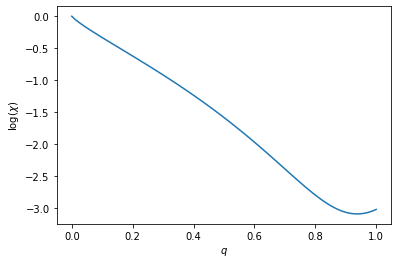

In [13]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)
#NoiseStrength = np.arange(0.0,1.1,0.1)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1/sp.sqrt(2),1/sp.sqrt(2),0]

gate_p = gl.choose_gate('p',1)
gate_q = gl.choose_gate('q',4)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,1,NoiseStrength[i],GammaValue,qubit_param)

log_hasil = np.log(hasil)

print(hasil)
plt.plot(NoiseStrength,log_hasil)
plt.ylabel('$\log(\chi$)')
plt.xlabel('$q$')

real_hasil = np.real(hasil)
print(np.argmin(real_hasil)/100)
print(np.min(real_hasil))
print(real_hasil[-1])

In [8]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
#NoiseStrength = np.arange(0.0,1.01,0.01)
NoiseStrength = np.arange(0.0,1.1,0.1)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [0,1,0]

gate_p = gl.choose_gate('p',1)
gate_q = gl.choose_gate('p',3)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,NoiseStrength[i],NoiseStrength[i],GammaValue,qubit_param)
    


print(hasil)

log_hasil = np.log2(hasil)

plt.plot(NoiseStrength,log_hasil)
plt.title('Holevo capacity for bitflip and dephasing noise')
plt.ylabel('$\log_2(\chi$)')
plt.xlabel('$q$')

TypeError: Holevo() missing 1 required positional argument: 'qubit_param'

[1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923e-32j 1.-2.23193923e-32j 1.-2.23193923e-32j
 1.-2.23193923

c:\Users\cahya\anaconda3\envs\SymbolicComputation\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


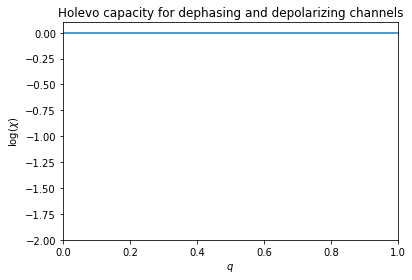

: 

In [ ]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)
#NoiseStrength = np.arange(0.0,1.1,0.1)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1,0,0]

gate_p = gl.choose_gate('p',0)
gate_q = gl.choose_gate('p',0)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,NoiseStrength[i],NoiseStrength[i],GammaValue,qubit_param)
    


print(hasil)

log_hasil = np.log(hasil)

plt.plot(NoiseStrength,log_hasil)
plt.title('Holevo capacity for dephasing and depolarizing channels')
plt.ylim([-2,0.1])
plt.xlim([0,1])
plt.ylabel('$\log(\chi$)')
plt.xlabel('$q$')

real_log_hasil = np.real(log_hasil)
print(np.argmin(real_log_hasil)/100)

0.0
0.048794940695398914
0.048794940695398914


c:\Users\cahya\anaconda3\envs\SymbolicComputation\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


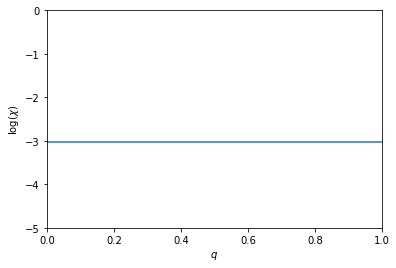

In [6]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]

gate_p = gl.choose_gate('p',3)
gate_q = gl.choose_gate('p',4)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,1,NoiseStrength[i],GammaValue,qubit_param)

log_hasil = np.log(hasil)

plt.plot(NoiseStrength,log_hasil)
plt.ylim([-5,0])
plt.xlim([0,1])
plt.ylabel('$\log(\chi$)')
plt.xlabel('$q$')


real_hasil = np.real(hasil)
print(np.argmin(real_hasil)/100)
print(np.min(real_hasil))
print(real_hasil[-1])

0.78
(0.3298504802027653+0j)
(0.34067489500866+1.3107800568446168e-65j)


c:\Users\cahya\anaconda3\envs\SymbolicComputation\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


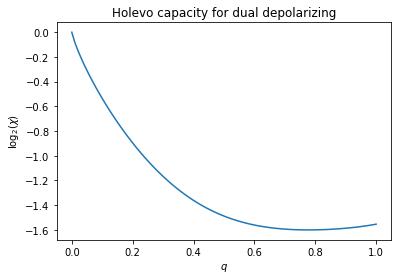

In [ ]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)
#NoiseStrength = np.arange(0.0,1.1,0.1)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1/np.sqrt(2),1/np.sqrt(2),0]

gate_p = gl.choose_gate('p',4)
gate_q = gl.choose_gate('p',4)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,NoiseStrength[i],NoiseStrength[i],GammaValue,qubit_param)
    


log_hasil = np.log2(hasil)


plt.plot(NoiseStrength,log_hasil)
plt.ylabel('$\log_2(\chi$)')
plt.xlabel('$q$')

real_log_hasil = np.real(log_hasil)
print(np.argmin(real_log_hasil)/100)
print(min(hasil))
print(hasil[-1])

c:\Users\cahya\anaconda3\envs\SymbolicComputation\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$q$')

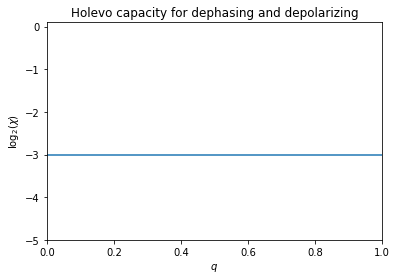

In [5]:

#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3



#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)
NoiseConstant = 1
#NoiseStrength = np.arange(0.0,1.1,0.1)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]

gate_p = gl.choose_gate('p',3)
gate_q = gl.choose_gate('p',4)

#Sekarang kita akan mencari hasil untuk tiap strength yang berbeda
hasil = np.zeros(len(NoiseStrength),dtype=complex)
for i in range(len(NoiseStrength)):
    hasil[i] = Holevo(rho_c,rho_t,gate_p,gate_q,NoiseConstant,NoiseStrength[i],GammaValue,qubit_param)
    


log_hasil = np.log(hasil)

plt.plot(NoiseStrength,log_hasil)
plt.title('Holevo capacity for dephasing and depolarizing')
plt.ylabel('$\log_2(\chi$)')
plt.ylim([-5,0.1])
plt.xlim([0,1])
plt.xlabel('$q$')

In [5]:
#Definisikan control qubit
gamma = sp.Symbol('gamma',real = True)
rho_c = Matrix([[gamma,sp.sqrt(gamma*(1-gamma))],[sp.sqrt(gamma*(1-gamma)),1-gamma]])

#Definisikan transmitted qubit
a = sp.Symbol('a',real = True)
b = sp.Symbol('b',real = True)
c = sp.Symbol('c',real = True)
pauli0 = sp.Matrix([[1,0],[0,1]])
pauli1 = sp.Matrix([[0,1],[1,0]])
pauli2 = sp.Matrix([[0,-sp.I],[sp.I,0]])
pauli3 = sp.Matrix([[1,0],[0,-1]])
rho_t = sp.Rational(1/2)*pauli0 + (a/2)*pauli1 + (b/2)*pauli2 + (c/2)*pauli3

#Kekuatan noise
NoiseStrength = np.arange(0.0,1.01,0.01)

#Nilai gamma
GammaValue = 1/2
GammaValue = simplify(GammaValue)

#Nilai parameter [a,b,c]
qubit_param = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]

gate_p = gl.choose_gate('p',1)
gate_q = gl.choose_gate('q',1)



x = NoiseStrength.copy()
y = NoiseStrength.copy()

X,Y = np.meshgrid(x,y)
Z = np.zeros([len(x),len(y)])


#for i in range(len(x)):
#    for j in range(len(y)):
#        Z[i,j] = np.real(complex(Holevo(rho_c,rho_t,gate_p,gate_q,x[i],y[j],GammaValue,qubit_param)))

#log_Z = np.real(np.log(Z))





In [16]:

pd.DataFrame(log_Z).to_csv("log_Z_11.csv")

In [6]:
import pandas as pd
log_Z = pd.read_csv('log_Z_13.csv', sep = ',').to_numpy()[:,1:]




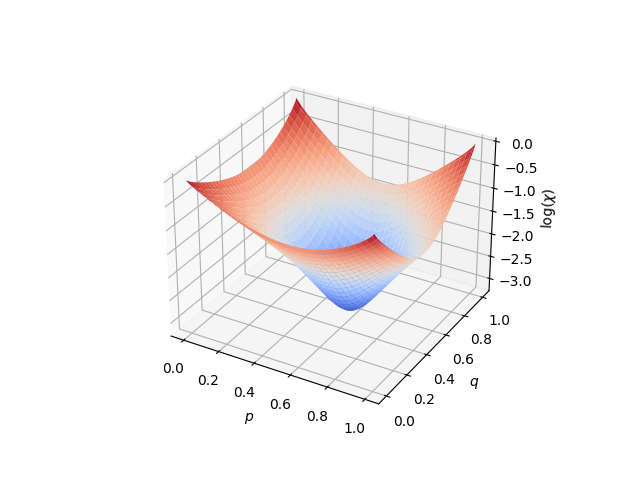

In [7]:
%matplotlib widget

from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(Y,X,log_Z,cmap = cm.coolwarm)
ax.set_xlabel('$p$')
ax.set_ylabel('$q$')
ax.set_zlabel('$\log(\chi)$')
#ax.scatter(0.50,0.50,)
plt.show()

In [8]:
print(np.min(log_Z))
print(np.where(log_Z == np.min(log_Z)))
print(log_Z[50,50])

-3.2120876618813585
(array([56], dtype=int64), array([56], dtype=int64))
-3.0201286457722105
